# Conv Net

In [1]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
# Install SimpleITK
!pip install SimpleITK
# Install tf-nightly
# !pip install tf-nightly

     |████████████████████████████████| 44.9MB 69kB/s 


In [4]:
import tensorflow as tf

print(tf.version)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>
Num GPUs Available:  1


In [5]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

## Image resize & rescale

(160, 160, 150)


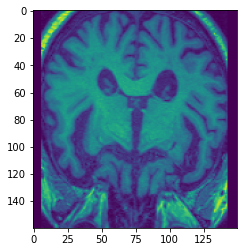

In [6]:
import SimpleITK as sitk

import matplotlib.pyplot as plt

image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))

np_image = sitk.GetArrayFromImage(image)
print(np_image.shape)
plt.imshow(np_image[80])

(160, 160, 150)
(112, 112, 105)
(112, 112, 105)


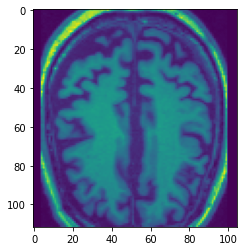

In [7]:
from matplotlib import pyplot as plt
from skimage.transform import resize, rescale

# new_img = np_image[:, :, 10:140]
new_img = np_image
print(new_img.shape)

resized = resize(new_img, (112, 112, 105))
print(resized.shape)

rescaled = rescale(new_img, 0.7)
print(rescaled.shape)

plt.imshow(resized[80, :, :])
# plt.imshow(rescaled[int(80 * 0.7), :, :])


## Image horizontal flip

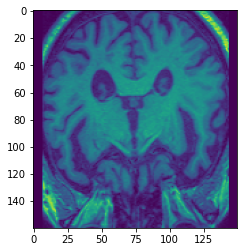

In [8]:
import numpy as np

flipped = np.flipud(np_image)

plt.imshow(flipped[80, :, ::-1])

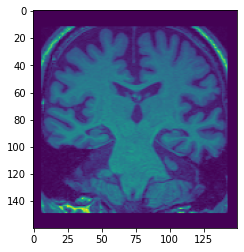

In [9]:
plt.imshow(tf.image.flip_up_down(np_image)[:, 80])

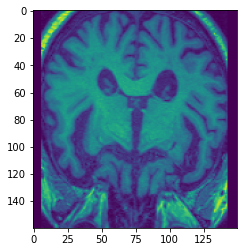

In [10]:
plt.imshow(tf.image.flip_up_down(flipped)[80])

## Image batch reading - MRISequence


In [11]:
len(os.listdir(saliencies_and_segmentations_v2_path))

502

In [12]:
import os
import math

import sklearn
import numpy as np
import SimpleITK as sitk

from keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from skimage.transform import resize


def process_image(path, input_shape, resize_img, normalization):
    x = sitk.GetArrayFromImage(sitk.ReadImage(path))
    if resize_img == True:
      x = resize(x, input_shape[:3])
    if normalization is not None:
      x = normalize(x, normalization)
    return np.array(x).reshape(input_shape)

def invert_img(x):
    # [x, y, z, 1]
    return x[:, :, ::-1, :]

def normalize(x, normalization):
    desc = normalization['desc']
    if normalization['type'] != 'standardization':
      return (x - desc['min']) / (desc['max'] - desc['min'])
    return (x - desc['mean']) / desc['std']

def augment_image(x, augment):
    if augment is None:
      return x

    if 'random_swap_hemispheres' in augment:
        p = augment['random_swap_hemispheres']
        if np.random.uniform(0) < p:
          return invert_img(x)

    return x

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class MRISequence(Sequence):
    def __init__(self,path, batch_size, input_shape, class_names=['AD', 'CN'], 
                 augment=None, images=True, one_hot=True, class_weight=None,
                 normalization=None, resize_img=True):
      if one_hot == False:
        self.encoder = LabelEncoder()
        self.encoder.fit(np.array(class_names))
      else:
        self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(np.array(class_names).reshape(-1, 1))

      self.class_weight = class_weight
      self.one_hot = one_hot
      self.input_shape = input_shape
      self.resize_img = resize_img
      self.class_names = class_names
      self.images = images
      self.augment = augment
      self.normalization = normalization

      self.batch_size = batch_size
      self.images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
        
    def __len__(self):
        return math.ceil(len(self.images_dirs) / self.batch_size)
        # Uncomment for debugging (when you need a smaller subset of data and faster training time)
        # return math.ceil(9 / self.batch_size)

    def __getitem__(self, idx):
        images_dirs = self.images_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if not len(images_dirs):
          return np.array([]).reshape(-1, input_shape), np.array([]).reshape(-1, input_shape)

        # if we disabled loading images, don't do it
        if not self.images:
          batch_x = np.array([None for image_dir in images_dirs])
        else:
          batch_x = np.array([process_image(os.path.join(image_dir, 'data.nii'), self.input_shape, self.resize_img, self.normalization) for image_dir in images_dirs])
          batch_x = np.array([augment_image(x, self.augment) for x in batch_x])

        batch_y = self.__encode(np.array([self.__readfile(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs]))
        
        if self.class_weight is None:
          return batch_x, batch_y
        
        batch_w = np.array([self.class_weight[y] for y in self.__decode(batch_y)])
        return batch_x, batch_y, batch_w

    def __encode(self, labels):
      if self.one_hot == True:
        labels = labels.reshape(-1, 1)
      return self.encoder.transform(labels)

    def __decode(self, labels):
      if self.one_hot == True:
          return np.argmax(labels, axis=1)
      return labels

    def __readfile(self, file_path):
        fo = open(file_path, "r")
        c = fo.readline()
        fo.close()
        return c

In [13]:
path = saliencies_and_segmentations_v2_path
encoder = LabelEncoder()
encoder.fit(np.array(['AD', 'CN']).reshape(-1, 1))
images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
images_dirs = images_dirs[:32]

def read_file(file_path):
  fo = open(file_path, "r")
  c = fo.readline()
  fo.close()
  return c

batch_y = np.array([read_file(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs])
encoder.transform(batch_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1])

In [14]:
path = saliencies_and_segmentations_v2_path
encoder = OneHotEncoder(sparse=False)
encoder.fit(np.array(['AD', 'CN']).reshape(-1, 1))
images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
images_dirs = images_dirs[:32]

def read_file(file_path):
  fo = open(file_path, "r")
  c = fo.readline()
  fo.close()
  return c

batch_y = np.array([read_file(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs])
encoder.transform(batch_y.reshape(-1, 1))

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [15]:
encoder.inverse_transform([[0.9, 0.5], [0.3, 0]]).reshape(-1)

array(['AD', 'AD'], dtype='<U2')

In [16]:
# saliances = [sitk.ReadImage(os.path.join(image_dir, 'data.nii')) for image_dir in images_dirs]
# np.array([sitk.GetArrayViewFromImage(raw_image).reshape((160, 160, 150, 1)) for raw_image in saliances])

(4, 112, 112, 105, 1) (4, 2)


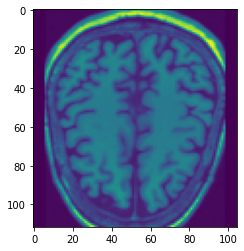

In [17]:
seq = MRISequence(saliencies_and_segmentations_v2_path, 4, input_shape=(112, 112, 105, 1))

for x, y in seq:
  print(x.shape, y.shape)
  plt.imshow(x[0][80].reshape(112, 105))
  break;

## Split data - train, test, val

In [18]:
import os
import time
import shutil
import numpy as np

from tqdm import tqdm


def train_test_split(src, dst, **kwargs):
  split = kwargs.get('split', (0.8, 0.1, 0.1))
  dirname = kwargs.get('dirname', str(int(time.time())))

  if len(split) != 3:
    raise "split mus be length of three!"

  if sum(split) != 1:
    raise "sum of split must be 1!"

  dst_dir = os.path.join(dst, f'{dirname}')
  train_dir = os.path.join(dst_dir, 'train')
  test_dir = os.path.join(dst_dir, 'test')
  val_dir = os.path.join(dst_dir, 'val')
  
  if os.path.exists(dst_dir):
    print("not copying files since the destination directory already exists")

    return train_dir, test_dir, val_dir

  os.mkdir(dst_dir)
  print(f"copying to {dst_dir}...\n")

  # list of directories to copy
  src_dirs = os.listdir(src)
  print('shuffling an array...')
  np.random.shuffle(src_dirs)

  print('copying files...')
  src_dirs_count = len(src_dirs)
  for idx, dir in tqdm(enumerate(src_dirs), total=src_dirs_count):
    dst_dir = train_dir

    if idx > split[0] * src_dirs_count:
      dst_dir = test_dir
    if idx > (split[0] + split[1]) * src_dirs_count:
      dst_dir = val_dir

    shutil.copytree(os.path.join(src, dir), os.path.join(dst_dir, dir))

  return train_dir, test_dir, val_dir


# train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/')

## 3D CNN

https://web.stanford.edu/~eadeli/publications/MICCAI_DeepAD_Final.pdf

In [19]:
import tensorflow as tf
import os

USE_TPU = False

if USE_TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)

  print("All devices: ", tf.config.list_logical_devices('TPU'))

### RandomSwapBrainHemisphere

In [20]:
import tensorflow as tf

from keras.layers import Lambda


@tf.function
def random_invert_img(x, p):
  if tf.random.uniform([]) < p:
    # [x, y, z, 1]
    return x[:, :, ::-1, :]
  return x

def RandomSwapBrainHemisphere(factor=0.5):
  return Lambda(lambda x: random_invert_img(x, factor))

### MRITensorBoardCallback

In [21]:
import io
import os
import itertools
import matplotlib.pyplot as plt

from keras.callbacks import Callback


def to_rgb_image(img, pred_label=None, true_label=None, z_index=None, add_batch_dim=True):
  figure = plt.figure(figsize=(4, 4))
  plt.imshow(img.reshape(img.shape[:-1])[z_index], cmap='gray')
  if true_label is not None and pred_label is not None:
    plt.title(f'true = {true_label}, pred = {pred_label}')
  return plot_to_image(figure, add_batch_dim)


def plot_to_image(figure, add_batch_dim=True):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside 
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  if add_batch_dim:
    # Add the batch dimension
    image = tf.expand_dims(image, 0)  
  return image


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix', fontsize=36)
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = 'white' if cm[i, j] > threshold else 'black'
    plt.text(j, i, labels[i, j], horizontalalignment='center', color=color, fontsize=18)

  plt.tight_layout()
  plt.ylabel('True label', fontsize=18)
  plt.xlabel('Predicted label', fontsize=18)
  return figure


class MRITensorBoardCallback(Callback):
    def __init__(self, seq, model, z_index=56, max_outputs=18, freq=3, log_dir=None, debug=True):
        """
        seq is the sequence from which is the data taken
        model to fit
        z_index is the index in the 3D image which is visualised
        log_dir is the where is output logged
        max_outputs number of images to output
        freq determines how frequently (each freq epoch) to outpu to tensorboard
        """
        super(MRITensorBoardCallback, self).__init__()
        self.model = model
        self.seq = seq
        self.log_dir = log_dir
        self.z_index = z_index
        self.max_outputs = max_outputs
        self.freq = freq
        self.debug = debug

    def __get_z_index(self, img):
      return max(min(img.shape[1], self.z_index), 0)

    def __debug(self, msg):
      if self.debug:
        print(msg)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.freq != 0:
        self.__debug('skipping evaluation of predictions to tensorboard')
        return

      self.__debug(f'evaluation of predictions to tensorboard for epoch #{epoch} (no of batches is {len(self.seq)})...')

      images = []
      class_names = self.seq.class_names
      y_pred = np.array([]).reshape(-1, len(class_names))
      y_true = np.array([]).reshape(-1, len(class_names))

      # Get predictions in batches for seq
      for index, batch in enumerate(self.seq):
        x, y, _ = batch
        self.__debug(f'batch #{index}')
        # Get predictions
        pred = self.model.predict(x)

        # Merge with other predictions
        y_true = np.concatenate([y_true, y])
        y_pred = np.concatenate([y_pred, pred])

        # Encode labels
        true_labels = self.seq.encoder.inverse_transform(y)
        pred_labels = self.seq.encoder.inverse_transform(pred)

        # Do not create more images than we output
        if len(images) >= self.max_outputs:
          continue;

        rgb_images = [to_rgb_image(image, pred_label=pred, true_label=true, z_index=self.z_index, add_batch_dim=False) for image, pred, true in zip(x, pred_labels.reshape(-1), true_labels.reshape(-1))]
        for rgb_image in rgb_images:
          images.append(rgb_image)

      # Create a confussion matrix
      cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
                                                                
      # Log the confusion matrix as an image summary.
      figure = plot_confusion_matrix(cm, class_names=class_names)
      cm_image = plot_to_image(figure)

      file_writer_cm = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/confussion-matrix'))
      file_writer_images = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/images'))

      with file_writer_images.as_default():
        # Don't forget to reshape.
        images = images[0:self.max_outputs]
        tf.summary.image("Validation Images", images, max_outputs=self.max_outputs, step=epoch)

      # Log the confusion matrix as an image summary.
      with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

#### Prototyping

In [22]:
import numpy as np

from sklearn import metrics

# Do not run this automatically when notebook is re-run
if False:
  _, _, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', dirname='1603829908')

  batch_size = 3
  input_shape = (112, 112, 105, 1)
  seq = MRISequence(val_dir, batch_size, input_shape=input_shape)
  print(len(seq))

  y_pred = np.array([])
  y_true = np.array([])

  for index, batch in enumerate(seq):
    x, y = batch
    y_true = np.concatenate([y_true, y])
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=1)])
    
  y_true_labels = seq.encoder.inverse_transform(y_pred)
  y_pred_bales = seq.encoder.inverse_transform(y_true)
  sklearn.metrics.confusion_matrix(y_true_labels, y_pred_bales)

In [23]:
from PIL import Image

import matplotlib.pyplot as plt

seq = MRISequence(saliencies_and_segmentations_v2_path, 4, input_shape=(112, 112, 105, 1))

# Get the first image
x, y = seq[0]
img = x[0]

figure = plt.figure(figsize=(8, 8))
plt.imshow(img.reshape(img.shape[:-1])[56], cmap='gray')
plt.title(f'true = AD, pred = CN')
image = plot_to_image(figure)

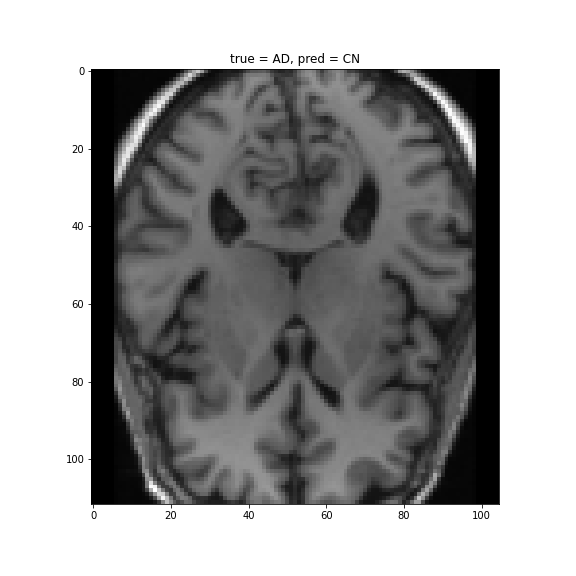

In [24]:
Image.fromarray(np.array(image[0]), mode='RGBA')

In [25]:
# Do not run this automatically when notebook is re-run
if False:
  log_dir = os.path.join(LOG_DIRECTORY, 'mri-tf-callback-demo')
  file_writer_images = tf.summary.create_file_writer(log_dir)

  with file_writer_images.as_default():    
      # tf.summary.image("Validation Images", [image], max_outputs=1, step=0)
      tf.summary.image("Training data", image, step=3)

In [26]:
# %tensorboard --reload_multifile=true --logdir "$log_dir"

### Debug layer

Not working...

In [27]:
import tensorflow as tf

from keras.layers import Layer


@tf.function
def to_tensorboard(inputs, z_index, log_dir, log_key, log_name, batch, max_outputs, epoch):
    rgb_images = [to_rgb_image(img, z_index=z_index, add_batch_dim=False) for img in inputs]
                  
    # Write images
    file_writer_images = tf.summary.create_file_writer(os.path.join(log_dir, f'train/{log_key}'))

    with file_writer_images.as_default():
      # Don't forget to reshape.
      rgb_images = rgb_images[0:max_outputs]
      tf.summary.image(f'{log_name} (Batch #{batch})', rgb_images, max_outputs=max_outputs, step=epoch)
      pass

class Debug(Layer):
  """
  Debug writes images from batches to the tensorboard.
  It writes image based on frequency (freq) param.
  """
  def __init__(self, log_dir=None, log_key=None, log_name=None, z_index=0, freq=1, seq_len=None):
    super(Debug, self).__init__(trainable=False)
    if seq_len is None:
      raise "seq_len is None!"
    if log_dir is None:
      raise "seq_len is None!"
    if log_key is None:
      raise "seq_len is None!"
    if log_name is None:
      raise "seq_len is None!"

    self.log_dir = log_dir
    self.log_key = log_key
    self.z_index = z_index
    self.freq = freq
    self.seq_len = seq_len
    self.batch = 0
    self.epoch = 1
    self.max_outputs = 100

  def get_config(self):
    return {
        "log_dir": self.log_dir,
        "log_key": self.log_key,
        "z_index": self.z_index,
        "freq": self.freq,
        "seq_len": self.seq_len,
        "batch": self.batch,
    };

  def build(self, input_shape):
    pass

  def call(self, inputs):
    self.batch += 1
    if self.batch > self.seq_len:
      self.batch = 1
      self.epoch += 1

    print(self.seq_len, self.batch)
    # -1 because we want to print the first image when freq = seq_len
    if (self.batch - 1) % self.freq == 0:
      tf.config.run_functions_eagerly(True)
      to_tensorboard(inputs, self.z_index)
      tf.config.run_functions_eagerly(False)

    return inputs

### Normalization layer

In [28]:
%time

from tqdm import tqdm
from keras.layers.experimental.preprocessing import Normalization

MAX_BATCHES = 12

train_x = []

print('preparing a normalization layer....')
for index, batch in tqdm(enumerate(seq)):
  batch_x, _ = batch
  for x in batch_x:
    train_x.append(x)
  if index >= MAX_BATCHES:
    break
  
# normalization = Normalization()
# normalization.adapt(train_x)

0it [00:00, ?it/s]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
preparing a normalization layer....


12it [02:03, 11.44s/it]

### Model.create_model()

In [29]:
from keras import Sequential
from keras.layers import Conv3D, MaxPool3D, Dense, Flatten, Dropout, Input, BatchNormalization
from keras.regularizers import L2

from keras.metrics import Recall, Precision, CategoricalAccuracy, AUC

from keras.losses import CategoricalCrossentropy, BinaryCrossentropy


def create_model(input_shape,
                 log_dir=None,
                 train_seq=None,
                 class_names=None,
                 output_bias=None,
                 normalization=None,
                 batch_norm=False,
                 is_complex=False,
                 **kwargs):
  """
  input_shape is (z, x, y, 1)
  log_dir of the tensorboard logs
  train_seq
  """
  # In the original paper, they experiment with dropout and L2 regularizers
  # they do not specify, where they put dropout layers, and on which layers they
  # apply what types of regularizations
  beta = kwargs.get('l2_beta', None) # TODO: add regularization to layers
  dropout= kwargs.get('dropout', None)

  model = Sequential()

  model.add(Input(shape=input_shape, name="input_layer"))
  
  # Preprocessing (normalization)
  if normalization is not None:
    model.add(Normalization())

  # THIS IS IMPLEMENTED IN SEQUENCE NOW
  # Augmention
  # model.add(RandomSwapBrainHemisphere(0.5))

  # NOT-WORKING
  # Debug output of previous layer to tensorboard as an image
  # Print the middle of the z index as an image
  # if log_dir is not None and train_seq is not None:
  #   model.add(Debug(
  #       log_dir=log_dir,
  #       log_key='augmented',
  #       log_name='Augmented Images',
  #       z_index=input_shape[0] // 2,
  #       # print only 2 batches from the epoch
  #       freq=len(train_seq) // 2,
  #       seq_len=len(train_seq)))

  # L1, L2
  # In the original paper they use input_shape=(116, 113, 83, 1), however it does not match
  # the proportions of our input shape
  model.add(Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=L2(l=beta), input_shape=input_shape))
  
  if is_complex:
    model.add(Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=L2(l=beta)))

  if batch_norm == True:
    model.add(BatchNormalization())

  # L3
  model.add(MaxPool3D(pool_size=(2, 2, 2), padding='same'))

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  # L4, L5
  model.add(Conv3D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=L2(l=beta)))

  if is_complex:
    model.add(Conv3D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=L2(l=beta)))

  if batch_norm == True:
    model.add(BatchNormalization())

  # L6
  model.add(MaxPool3D(pool_size=(3, 3, 3)))

  # Dropout
  if dropout == True:
    model.add(Dropout(dropout))

  # L7, L8
  model.add(Conv3D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=L2(l=beta)))

  if is_complex:
    model.add(Conv3D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=L2(l=beta)))

  if batch_norm == True:
    model.add(BatchNormalization())

  # L9
  model.add(MaxPool3D(pool_size=(4, 4, 4)))

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  # Flatten
  model.add(Flatten())

  # L10
  if is_complex:
    model.add(Dense(512, kernel_regularizer=L2(l=beta)))

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  # L11
  model.add(Dense(256, kernel_regularizer=L2(l=beta)))

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  # Output
  model.add(Dense(len(class_names), activation='softmax', bias_initializer=output_bias))

  # Finally compile the model!
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=kwargs.get('learning_rate', 0.001), beta_1=0.9, beta_2=0.999),
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
    loss=CategoricalCrossentropy(),
    # loss=BinaryCrossentropy(),
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    metrics=[Recall(), Precision(), AUC(), CategoricalAccuracy()],
    # metrics=[CategoricalAccuracy()],
  )

  return model

### Model.train()


In [30]:
import datetime


def train(model, train_seq, val_seq, **kwargs):
  global CHECKPOINT_DIRECTORY
  global LOG_DIRECTORY

  input_shape = train_seq.input_shape
  model_key = kwargs.get('model_key', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  print(f'model key: {model_key}')

  checkpoint_dir = os.path.join(CHECKPOINT_DIRECTORY, model_key)
  log_dir = os.path.join(LOG_DIRECTORY, model_key)
  image_log_dir = os.path.join(IMAGE_LOG_DIRECTORY, model_key)

  print(f'checkpoint dir - {checkpoint_dir}')
  print(f'log dir - {log_dir}')

  callbacks = [
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
      tf.keras.callbacks.TensorBoard(
          log_dir=os.path.join(log_dir),
          update_freq=4,
          histogram_freq=1,
          profile_batch=0
      ),
      tf.keras.callbacks.ModelCheckpoint(
          os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt'),          
          monitor='val_loss',
          save_weights_only=True,
          verbose=2,
          # save_best_only=True,
      ),
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping 
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=kwargs.get('patience', 10), # Number of epochs with no improvement after which training will be stopped.
          restore_best_weights=True,
      ),
      MRITensorBoardCallback(val_seq, model, z_index=input_shape[0] // 2, freq=1, log_dir=log_dir, debug=False),
  ]

  # train the model
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
  print('training...')
  history = model.fit(
      train_seq,
      validation_data=val_seq,
      epochs=kwargs.get('epochs', 50),
      workers=1,
      verbose=1,
      callbacks=callbacks,
      class_weight=kwargs.get('class_weight', None),
  )

  return model, checkpoint_dir, history

### Training

In [31]:
def get_description(norm_seq, max_samples=64):
  train_x = []  

  for index, batch in enumerate(norm_seq):
      batch_x, _ = batch                     
      for x in batch_x:
        train_x.append(x)
      if max_samples is not None and len(train_x) >= max_samples:
        break
  
  return {'mean': np.mean(train_x), 'std': np.std(train_x), 'min': np.min(train_x), 'max': np.max(train_x) }

#### Setup

In [32]:
%%time

import datetime

# https://github.com/timzatko/fiit-nsiete/blob/master/src/model.py

# constants
LOG_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'logs')
IMAGE_LOG_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'image-logs')
CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'checkpoints')

if not os.path.exists(CHECKPOINT_DIRECTORY):
  os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
  os.mkdir(LOG_DIRECTORY)

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', split=(0.8, 0.15, 0.05), dirname='data-v2')

# set the batch size
batch_size = 12
input_shape = (112, 112, 105, 1)
resize_img=True

# batch_size = 4
# input_shape = (160, 160, 150, 1)
# resize_img=False

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weight = {0: 0.8271604938271606, 1: 1.2641509433962266}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
  print('initializing desc...')
  desc = get_description(MRISequence(
    train_dir,
    64,
    class_names=class_names,
    input_shape=input_shape), max_samples=None)
  print(desc)
  
normalization={'type':'normalization', 'desc':desc }
# normalization={'type':'standardization', 'desc':desc }

print('initializing train_seq...')
# initialize sequence
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augment={'random_swap_hemispheres': 0.5},
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing val_seq...')
val_seq = MRISequence(
    val_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    normalization=normalization)

not copying files since the destination directory already exists
initializing train_seq...
initializing val_seq...
initializing test_seq...
CPU times: user 7.81 ms, sys: 195 µs, total: 8.01 ms
Wall time: 3.69 s


In [33]:
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

log_dir: /content/gdrive/My Drive/logs/20201115-094318


In [40]:
tf.config.run_functions_eagerly(False)

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([243/159])

model = create_model(
    input_shape,
    log_dir=log_dir, 
    train_seq=train_seq,
    class_names=class_names,
    l2_beta=0.001,
    dropout=0.15,
    # dropout=None,
    output_bias=initial_bias,
    learning_rate=0.025,
    # normalization=normalization, # normalization layer
    batch_norm=False,
    is_comlex=False, # a complex layer from the paper, max batch_size is 3
)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 112, 112, 105, 32) 896       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 56, 56, 53, 32)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 53, 32)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 56, 56, 53, 64)    55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 18, 18, 17, 64)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 18, 18, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 4, 4, 4, 128)     

#### Tensorboard

In [35]:
# %tensorboard --logdir "$log_dir"
# %tensorboard  --reload_multifile=true --logdir "$LOG_DIRECTORY"

In [36]:
# TPU Support
# https://towardsdatascience.com/how-to-colab-with-tpu-98e0b4230d9c
# strategy = tf.distribute.TPUStrategy(resolver)

if USE_TPU:
  with strategy.scope():
      model = create_model()
      train(model)

#### Train

In [39]:
# load previously trained model
# 85 + 63
# CHECKPOINT_PATH=os.path.join('/content/gdrive/My Drive/', 'checkpoints', '20201113-091456', 'cp-0063.ckpt')
# model.load_weights(CHECKPOINT_PATH)

In [41]:
tf.executing_eagerly()
 
 
model, checkpoint_dir, history = train(
    model,
    train_seq,
    val_seq,
    model_key=model_key,
    epochs=100,
    patience=100,
)

model key: 20201115-094318
checkpoint dir - /content/gdrive/My Drive/checkpoints/20201115-094318
log dir - /content/gdrive/My Drive/logs/20201115-094318
training...
Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 63.8265 - recall_1: 0.5199 - precision_1: 0.5199 - auc_1: 0.4942 - categorical_accuracy: 0.5199 
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoints/20201115-094318/cp-0001.ckpt
34/34 [==============================] - 1037s 30s/step - loss: 63.8265 - recall_1: 0.5199 - precision_1: 0.5199 - auc_1: 0.4942 - categorical_accuracy: 0.5199 - val_loss: 18.0503 - val_recall_1: 0.6400 - val_precision_1: 0.6400 - val_auc_1: 0.6752 - val_categorical_accuracy: 0.6400
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 17.0331 - recall_1: 0.4876 - precision_1: 0.4876 - auc_1: 0.4886 - categorical_accuracy: 0.4876
Epoch 00002: saving model to /content/gdrive/My Drive/checkpoints/20201115-094318/cp-0002.ckpt
34/34 [=======================

In [50]:
# latest_checkpoint_path = tf.train.latest_checkpoint(os.path.join(CHECKPOINT_DIRECTORY, model_key))
# model.load_weights(latest_checkpoint_path)

In [51]:
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics =  ['loss', 'auc_1', 'precision_1', 'recall_1']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n + 1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5, 1])
    else:
      plt.ylim([0,1])

    plt.legend()

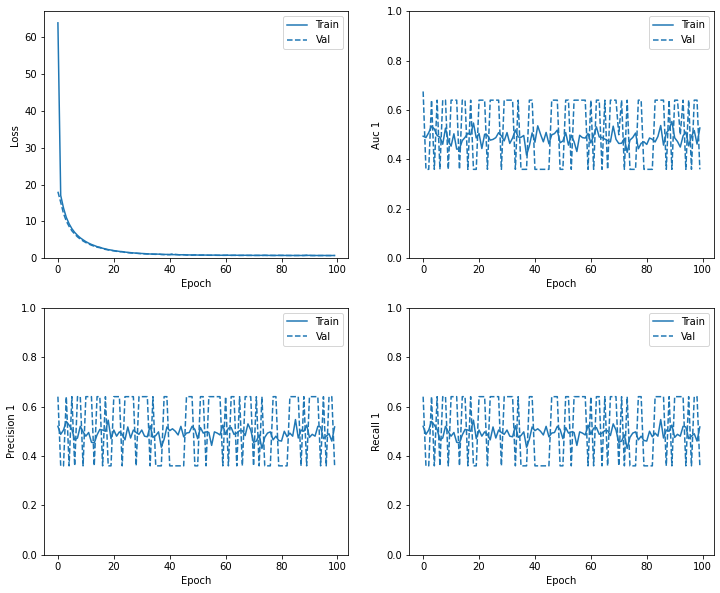

In [52]:
plot_metrics(history)

#### Test

In [53]:
from sklearn.metrics import classification_report, mean_squared_error, mean_squared_log_error, explained_variance_score, f1_score


def custom_classification_report(class_names, y_true, y_pred, **kwargs):
    clf_report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Custom print because of incorrect formatting of original function
    for key in clf_report:
        if isinstance(clf_report[key], dict):
            print(f'\033[1m{key}\033[0m')

            for metric in clf_report[key]:
                print(f'{metric}: {clf_report[key][metric]}')
        else:
            print(f'{key}: {clf_report[key]}')

        print('\n')
        
    print(f'\033[1mF1\033[0m')
    for average in ['micro', 'macro']:
        print(f'{average}: {f1_score(y_true, y_pred, average=average)}')
    print('\n')

In [54]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('AD Correctly Detected (True Negatives): ', cm[0][0])
    print('AD Incorrectly Detected (False Positives): ', cm[0][1])
    print('CN Missed (False Negatives): ', cm[1][0])
    print('CN Detected (True Positives): ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

In [55]:
baseline_results = model.evaluate(test_seq, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(f'{name}: {value}')
print()

loss: 0.8289119601249695
recall_1: 0.30666667222976685
precision_1: 0.30666667222976685
auc_1: 0.30666667222976685
categorical_accuracy: 0.30666667222976685



In [56]:
# check what the model does
for x, y, w in train_seq:
   pred = model.predict(x)
   print(pred, y, w)
   break;

[[0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]
 [0.41237545 0.58762455]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]] [0.82716049 0.82716049 0.82716049 0.82716049 0.82716049 1.26415094
 1.26415094 1.26415094 1.26415094 0.82716049 0.82716049 0.82716049]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AD
precision: 0.0
recall: 0.0
f1-score: 0.0
support: 52


CN
precision: 0.30666666666666664
recall: 1.0
f1-score: 0.4693877551020408
support: 23


micro avg
precision: 0.30666666666666664
recall: 0.30666666666666664
f1-score: 0.30666666666666664
support: 75


macro avg
precision: 0.15333333333333332
recall: 0.5
f1-score: 0.2346938775510204
support: 75


weighted avg
precision: 0.09404444444444443
recall: 0.30666666666666664
f1-score: 0.1439455782312925
support: 75


samples avg
precision: 0.30666666666666664
recall: 0.30666666666666664
f1-score: 0.30666666666666664
support: 75


F1
micro: 0.30666666666666664
macro: 0.2346938775510204




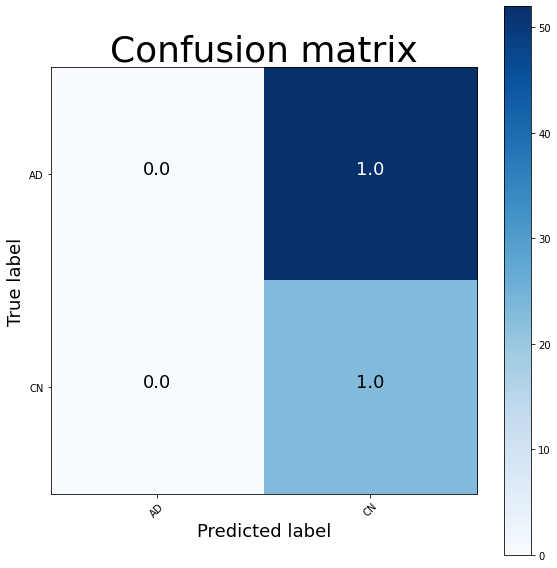

In [57]:
from keras.metrics import CategoricalAccuracy

acc = CategoricalAccuracy()

y_true = np.array([]).reshape(-1, len(class_names))
y_pred = np.array([]).reshape(-1, len(class_names))

for batch in test_seq:
  x, y = batch

  pred = model.predict(x)
  
  y_true = np.concatenate([y_true, y])
  y_pred = np.concatenate([y_pred, pred])


y_true_labels = encoder.transform(test_seq.encoder.inverse_transform(y_true).reshape(-1, 1))
y_pred_labels = encoder.transform(test_seq.encoder.inverse_transform(y_pred).reshape(-1, 1))

# Plot the confussion matrix
cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, class_names)

# Plot the metrics
custom_classification_report(class_names, y_true_labels, y_pred_labels)

## Other

In [58]:
# from keras.metrics import CategoricalAccuracy

# test_seq = MRISequence(test_dir, batch_size, class_names=class_names, input_shape=input_shape, one_hot=False)
# acc = CategoricalAccuracy()

# y_true = np.array([]).reshape(-1, len(class_names))
# y_pred = np.array([]).reshape(-1, len(class_names))

# for batch in test_seq:
#   x, y = batch

#   pred = model.predict(x)

#   y_true = np.concatenate([y_true, y])
#   y_pred = np.concatenate([y_pred, pred])


# y_true_labels = encoder.transform(test_seq.encoder.inverse_transform(y_true).reshape(-1, 1))
# y_pred_labels = encoder.transform(test_seq.encoder.inverse_transform(y_pred).reshape(-1, 1))

# # Plot the confussion matrix
# cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
# plot_confusion_matrix(cm, class_names)

# # Plot the metrics
# custom_classification_report(class_names, y_true_labels, y_pred_labels)

In [59]:
# print('loading best model...')
# latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest_checkpoint_path)
# print('best model loaded!')

In [60]:
# val_seq = MRISequence(val_dir, batch_size, input_shape=input_shape)

# x, y = val_seq.getitem(0)
# print(x.shape, y.shape)

In [61]:
# # https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/gpu.ipynb#scrollTo=hPI--n_jhZhv
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)